<a href="https://colab.research.google.com/github/joaqgonzar/pCCA-Hippocampus/blob/main/pCCA_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from matplotlib import gridspec
from scipy import stats

## Define Poisson Spiking Network

Define binning and network plotting functions

In [11]:
import numpy as np

def simulate_poisson_neurons_multi_modulated(
    num_populations=3,
    neurons_per_population=20,
    simulation_duration_ms=1000,
    dt_ms=10,
    base_firing_rate_hz=10,

    # Cross-population modulation
    modulator_neuron_idx=(2, 0),
    modulated_neuron_indices=[(0, 1), (1, 0)],
    modulation_strength_hz=50,      # Pop2 -> Pop0 & Pop1
    self_modulation_strength_hz=30, # Pop0 -> Pop1

    # Local intra-population modulation
    local_W=None,                   # list of symmetric local connectivity matrices
    local_strength_hz=5             # scaling factor for local connectivity
):
    """
    Simulates Poisson spiking for multiple populations with:
    - Cross-population modulation (Pop2→Pop0/1, Pop0→Pop1)
    - Local intra-population modulation (symmetric, instantaneous)

    All interactions are applied *instantaneously* within the same timestep without directional bias.
    """

    num_timesteps = int(simulation_duration_ms / dt_ms)
    base_rate_per_dt = base_firing_rate_hz * dt_ms / 1000.0
    mod_strength_per_dt = modulation_strength_hz * dt_ms / 1000.0
    self_mod_strength_per_dt = self_modulation_strength_hz * dt_ms / 1000.0
    local_scale_per_dt = local_strength_hz * dt_ms / 1000.0

    # IDs for clarity
    mod2_p, mod2_n = modulator_neuron_idx
    p0n0_coords = (0, 0)
    p1n0_coords = (1, 0)

    # If no local connectivity provided, generate symmetric ones
    if local_W is None:
        local_W = []
        for _ in range(num_populations):
            W = np.random.rand(neurons_per_population, neurons_per_population)
            np.fill_diagonal(W, 0.0)
            W = 0.5 * (W + W.T)  # symmetric for reciprocity
            local_W.append(W)
    else:
        assert len(local_W) == num_populations
        for W in local_W:
            assert W.shape == (neurons_per_population, neurons_per_population)

    # Scale local matrices
    local_W_scaled = [W * local_scale_per_dt for W in local_W]

    # Storage for spike times
    all_neurons_spike_times = {
        f"P{p_idx}N{n_idx}": []
        for p_idx in range(num_populations)
        for n_idx in range(neurons_per_population)
    }

    # --- Simulation loop ---
    for t in range(num_timesteps):
        current_time_ms = t * dt_ms

        # === STEP 1: Baseline + cross-population modulation ===
        # We'll compute all spike probabilities BEFORE any local interactions
        spike_probs = [
            np.full(neurons_per_population, base_rate_per_dt)
            for _ in range(num_populations)
        ]

        # Check if Pop2N0 spikes this timestep
        mod2_spikes = np.random.rand() < base_rate_per_dt
        if mod2_spikes:
            all_neurons_spike_times[f"P{mod2_p}N{mod2_n}"].append(current_time_ms)
            # boost Pop0N0 and Pop1N10 instantly
            for (pp, nn) in modulated_neuron_indices:
                spike_probs[pp][nn] += mod_strength_per_dt

        # Check if Pop0N0 spikes (baseline + possibly boosted by Pop2)
        p0n0_prob = base_rate_per_dt + (mod_strength_per_dt if mod2_spikes else 0.0)
        p0n0_spikes = np.random.rand() < p0n0_prob
        if p0n0_spikes:
            all_neurons_spike_times["P0N0"].append(current_time_ms)
            # boost Pop1N0 instantly
            spike_probs[1][0] += self_mod_strength_per_dt

        # === STEP 2: Sample all other neurons baseline/cross interactions ===
        # For all neurons except modulators already handled
        for p_idx in range(num_populations):
            for n_idx in range(neurons_per_population):
                # skip mod2 & p0n0
                if (p_idx, n_idx) in [modulator_neuron_idx, p0n0_coords]:
                    continue

                if np.random.rand() < spike_probs[p_idx][n_idx]:
                    all_neurons_spike_times[f"P{p_idx}N{n_idx}"].append(current_time_ms)

        # === STEP 3: Collect WHO actually spiked this timestep ===
        # Create boolean mask for local connectivity
        local_spikes = [np.zeros(neurons_per_population, dtype=bool) for _ in range(num_populations)]
        for p_idx in range(num_populations):
            for n_idx in range(neurons_per_population):
                neuron_id = f"P{p_idx}N{n_idx}"
                if len(all_neurons_spike_times[neuron_id]) > 0 and all_neurons_spike_times[neuron_id][-1] == current_time_ms:
                    local_spikes[p_idx][n_idx] = True

        # === STEP 4: Apply LOCAL interactions instantaneously ===
        # Now every neuron feels *all other spikes* from the SAME timestep simultaneously
        for p_idx in range(num_populations):
            if np.any(local_spikes[p_idx]):  # at least one spiked
                # Compute local extra rates for all neurons in this population
                local_inputs = local_W_scaled[p_idx] @ local_spikes[p_idx].astype(float)

                # Sample EXTRA spikes caused by local input
                for n_idx in range(neurons_per_population):
                    # Don't double-trigger already spiked neurons
                    if local_spikes[p_idx][n_idx]:
                        continue
                    extra_rate = local_inputs[n_idx]
                    if extra_rate > 0 and np.random.rand() < extra_rate:
                        all_neurons_spike_times[f"P{p_idx}N{n_idx}"].append(current_time_ms)
                        # Mark as spiked (to avoid double counting, though no further local step)
                        local_spikes[p_idx][n_idx] = True

    return all_neurons_spike_times

#%%

def convert_spikes_to_binned_matrices(
    spike_times_dict,
    num_populations,
    neurons_per_population,
    simulation_duration_ms,
    bin_size_ms=1
):
    """
    Converts raw spike times into binned spike count matrices for each population.
    (This function is identical to the previous implementation)
    """
    if simulation_duration_ms % bin_size_ms != 0:
        print(f"Warning: Simulation duration ({simulation_duration_ms} ms) is not perfectly divisible by bin size ({bin_size_ms} ms). Last bin might be partial.")

    num_bins = int(np.ceil(simulation_duration_ms / bin_size_ms))
    binned_spike_matrices = {}

    for p_idx in range(num_populations):
        binned_spike_matrices[p_idx] = np.zeros((neurons_per_population, num_bins), dtype=int)

        for n_idx in range(neurons_per_population):
            neuron_id = f"P{p_idx}N{n_idx}"
            spikes = spike_times_dict[neuron_id]

            for spike_time in spikes:
                bin_idx = int(spike_time / bin_size_ms)
                if bin_idx < num_bins:
                    binned_spike_matrices[p_idx][n_idx, bin_idx] += 1
    return binned_spike_matrices

import matplotlib.pyplot as plt
import numpy as np

def plot_neuron_network(
    neurons_per_population=20,
    modulation_strength_hz=50,        # Pop Z→Pop X & Pop Y
    self_modulation_strength_hz=20,   # Pop X→Pop Y
    local_modulation_strength_hz=20,   # Pop X→Pop Y
    local_W=None,                     # list of local connectivity matrices
    cluster_radius=2.0,
    inter_cluster_distance=5.0,
    local_edge_threshold=0.2          # only show local edges > this value
):
    """
    Plots 3 populations (20 neurons each) arranged as clusters of nodes.
    - Shows cross-population edges (Pop Z0→Pop X0 & Pop Y0; Pop X0→Pop Y0)
    - Shows intra-population connectivity from local_W matrices

    local_W should be a list of np.array, one per population.
    """

    pops = ["Pop X", "Pop Y", "Pop Z"]

    # Centers of the 3 clusters (triangle layout)
    angles = np.linspace(0, 2*np.pi, 4)[:-1]
    centers = [
        (inter_cluster_distance*np.cos(a), inter_cluster_distance*np.sin(a))
        for a in angles
    ]

    # Arrange neurons in each cluster
    neuron_positions = {}
    for pop_idx, pop_name in enumerate(pops):
        cx, cy = centers[pop_idx]
        theta = np.linspace(0, 2*np.pi, neurons_per_population, endpoint=False)
        for i, angle in enumerate(theta):
            x = cx + cluster_radius * np.cos(angle)
            y = cy + cluster_radius * np.sin(angle)
            neuron_positions[(pop_name, i)] = (x, y)

    #plt.figure(figsize=(10, 10))

    # --- Draw neurons ---
    for (pop_name, i), (x, y) in neuron_positions.items():
        plt.scatter(x, y, s=200, color="white", edgecolor="k", zorder=3)
        plt.text(x, y-0.3, i,
                 ha="center", fontsize=8)

    # ===========================
    # 1) LOCAL CONNECTIVITY
    # ===========================
    if local_W is not None:
        assert len(local_W) == 3, "Need one local matrix per population"

        for pop_idx, pop_name in enumerate(pops):
            W = local_W[pop_idx]
            # normalize for plotting
            if np.max(W) > 0:
                W_norm = W / np.max(W)
            else:
                W_norm = W.copy()
            #W_norm = W
            # iterate over edges i→j
            for i in range(neurons_per_population):
                for j in range(neurons_per_population):
                    if i == j:
                        continue  # no self
                    weight = W_norm[j, i]  # note: j receives from i
                    #weight = local_modulation_strength_hz
                    if weight > local_edge_threshold:
                        # positions
                        x1, y1 = neuron_positions[(pop_name, i)]
                        x2, y2 = neuron_positions[(pop_name, j)]

                        # line thickness scaled
                        lw = 2 * weight
                        lw = 0.05 * local_modulation_strength_hz

                        plt.plot([x1, x2], [y1, y2],
                                 linewidth=lw,
                                 color="red",
                                 alpha=1,
                                 zorder=1)

    # ===========================
    # 2) CROSS-POPULATION EDGES
    # ===========================
    cross_edges = [
        (("Pop Z", 0), ("Pop X", 0), modulation_strength_hz),
        (("Pop Z", 0), ("Pop Y", 0), modulation_strength_hz),
        (("Pop X", 0), ("Pop Y", 0), self_modulation_strength_hz),
    ]
    all_weights = [w for _, _, w in cross_edges]
    max_w = max(all_weights)
    for src, tgt, weight in cross_edges:
        x1, y1 = neuron_positions[src]
        x2, y2 = neuron_positions[tgt]
        lw =  0.05 * weight
        #lw = 0.01 * self_modulation_strength_hz
        plt.plot([x1, x2], [y1, y2],
                 linewidth=lw, color="black", alpha=1, zorder=2)

    # ===========================
    # 3) LABEL POPULATIONS
    # ===========================
    for pop_idx, pop_name in enumerate(pops):
        cx, cy = centers[pop_idx]
        plt.text(cx, cy + cluster_radius + 1.5, pop_name,
                 ha="center", fontsize=14)

    plt.axis("equal")
    plt.axis("off")

    #plt.show()


## Example usage with simulated data

Generate Poisson Spiking Network


Text(0.5, 0.98, 'Modulation Strength Z -> X,Y = 5.0\n Modulation Strength X->Y Interaction = 5.0\n Modulation Strength Local = 10.0')

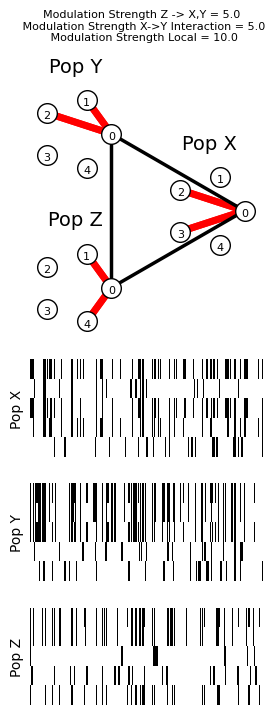

In [39]:
neurons_per_population = 5

# local connectivity parameters
W0 = np.zeros([neurons_per_population, neurons_per_population])
W0[3,0] = 1
W0[0,3] = 1
W0[2,0] = 1
W0[0,2] = 1

W1 = np.zeros([neurons_per_population, neurons_per_population])
W1[1,0] = 1
W1[0,1] = 1
W1[2,0] = 1
W1[0,2] = 1

W2 = np.zeros([neurons_per_population, neurons_per_population])
W2[1,0] = 1
W2[0,1] = 1
W2[4,0] = 1
W2[0,4] = 1

local_matrices = [W0, W1, W2]

# simulation parameters
modulation_strength_third_party = 50
modulation_strength_interaction = 50
modulation_strength_local = 100
simulation_duration = 100000
bin_size_for_plotting = 10
base_firing_rate_hz = 10

# Run simulation with fixed connectivity
raw_spike_data = simulate_poisson_neurons_multi_modulated(
    dt_ms = bin_size_for_plotting,
    num_populations=3,
    neurons_per_population=neurons_per_population,
    simulation_duration_ms=simulation_duration,
    modulation_strength_hz=modulation_strength_third_party,
    self_modulation_strength_hz=modulation_strength_interaction,
    base_firing_rate_hz = base_firing_rate_hz,
    local_W=local_matrices,    # <--- HERE you pass your fixed matrices
    local_strength_hz=modulation_strength_local        # scale factor for local connectivity
)

binned_outputs = convert_spikes_to_binned_matrices(
    raw_spike_data,
    num_populations=3,
    neurons_per_population=neurons_per_population,
    simulation_duration_ms=simulation_duration,
    bin_size_ms=bin_size_for_plotting
)


# You can access the matrices like this:
pop0_matrix = binned_outputs[0]
pop1_matrix = binned_outputs[1]
pop2_matrix = binned_outputs[2]

datax = stats.zscore(pop0_matrix.T,axis = 0)
datay = stats.zscore(pop1_matrix.T,axis = 0)
dataz = stats.zscore(pop2_matrix.T,axis = 0)


plt.figure(figsize = (3,8))
gs = gridspec.GridSpec(4, 1, height_ratios = (2.5,1,1,1))


plt.subplot(gs[0])

plot_neuron_network(
    neurons_per_population=neurons_per_population,
    modulation_strength_hz=modulation_strength_third_party,
    local_modulation_strength_hz = modulation_strength_local,
    self_modulation_strength_hz=modulation_strength_interaction,
    local_W=local_matrices,
    local_edge_threshold=0  # only draw strongest 40% local edges
)

plt.subplot(gs[1])
plt.imshow(pop0_matrix,aspect = 'auto', cmap = 'Greys', interpolation = 'nearest')
plt.xlim([0,200])
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.ylabel('Pop X')

plt.subplot(gs[2])
plt.imshow(pop1_matrix,aspect = 'auto', cmap = 'Greys', interpolation = 'nearest')
plt.xlim([0,200])
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.ylabel('Pop Y')

plt.subplot(gs[3])
plt.imshow(pop2_matrix,aspect = 'auto', cmap = 'Greys', interpolation = 'nearest')
plt.xlim([0,200])
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.ylabel('Pop Z')
#plt.hlines(0,100,150)

plt.suptitle('Modulation Strength Z -> X,Y = ' + str(modulation_strength_third_party/base_firing_rate_hz)+'\n Modulation Strength X->Y Interaction = ' + str(modulation_strength_interaction/base_firing_rate_hz)+'\n Modulation Strength Local = ' + str(modulation_strength_local/base_firing_rate_hz), fontsize = 8)

## Install partial_CCA package


In [3]:
pip install partial_CCA

Looking in indexes: https://test.pypi.org/simple/


## Apply pCCA to simulated data

In [40]:
from partial_CCA import PartialCCA

# define class and fit data
pCCA = PartialCCA()

# split data for cross-validation
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test, Z_train, Z_test = train_test_split(datax, datay, dataz, test_size=0.4, random_state=42)

pCCA.fit(X_train,Y_train, Z_train)
canonical_correlations = pCCA.canonical_correlations_

# Access weights
wx = pCCA.weights_x_
wy = pCCA.weights_y_

# get pvalues for each pCCA subspace based on surrogates
p_values, r_surr = pCCA.surrogate_test(datax,datay,dataz)

# Access subspace projection on local activity if neeeded (there is also a fit_transform method)
proj_X, proj_Y = pCCA.transform(datax,datay)  # shape: (n_components, n_samples)

# get correlation coefficient with witheld data useful for cross-validation
cross_validated_cannonical_correlations = pCCA.score(X_test,Y_test)

## Plot results

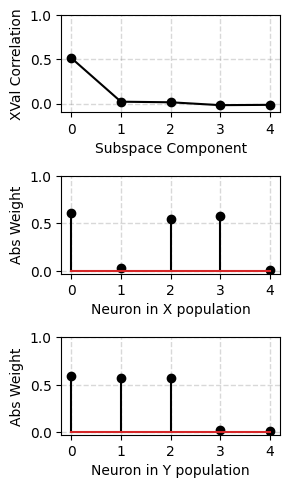

In [41]:
plt.figure(figsize = (3,8))

plt.subplot(gs[1])
plt.plot(cross_validated_cannonical_correlations,'-o', color = 'black')
plt.ylabel('XVal Correlation')
plt.xlabel('Subspace Component')
plt.ylim([-0.1,1])
plt.yticks(np.arange(0,1.1,0.5))
plt.grid(color='grey', linestyle='--', linewidth=1 ,alpha = 0.3, axis = 'both')

plt.subplot(gs[2])
markerline, stemlines, baseline = plt.stem(np.abs(wx[:,0]),markerfmt='k')
plt.setp(stemlines, 'color', 'k')
plt.ylabel('Abs Weight')
plt.xlabel('Neuron in X population')
plt.yticks(np.arange(0,1.1,0.5))
plt.grid(color='grey', linestyle='--', linewidth=1 ,alpha = 0.3, axis = 'both')

plt.subplot(gs[3])
markerline, stemlines, baseline = plt.stem(np.abs(wy[:,0]),markerfmt='k')
plt.setp(stemlines, 'color', 'k')
plt.ylabel('Abs Weight')
plt.xlabel('Neuron in Y population')
plt.yticks(np.arange(0,1.1,0.5))
plt.grid(color='grey', linestyle='--', linewidth=1 ,alpha = 0.3, axis = 'both')

plt.tight_layout()
plt.show()

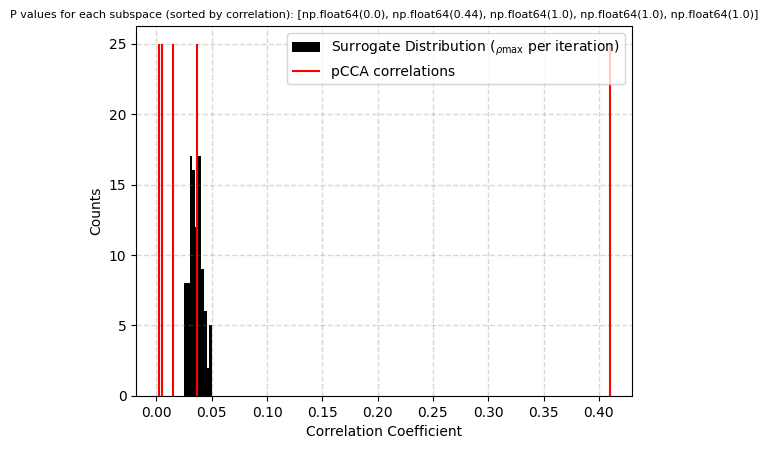

In [42]:
plt.subplot(111)

plt.hist(r_surr, color='black', label=r'Surrogate Distribution ($_{\rho\max}$ per iteration)')
plt.title('P values for each subspace (sorted by correlation): '+str(p_values), fontsize = 8)
plt.vlines(canonical_correlations,0,25, color = 'red', label = 'pCCA correlations')
plt.xlabel('Correlation Coefficient')
plt.legend()
plt.ylabel('Counts')
plt.grid(color='grey', linestyle='--', linewidth=1 ,alpha = 0.3, axis = 'both')